Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.9134, Train Acc: 34.25%, Test Loss: 1.8854, Test Acc: 37.20%
Epoch 2/10, Train Loss: 1.7980, Train Acc: 40.91%, Test Loss: 1.5763, Test Acc: 51.42%
Epoch 3/10, Train Loss: 1.6109, Train Acc: 51.01%, Test Loss: 1.3919, Test Acc: 62.44%
Epoch 4/10, Train Loss: 1.5187, Train Acc: 55.94%, Test Loss: 1.3342, Test Acc: 64.98%
Epoch 5/10, Train Loss: 1.4587, Train Acc: 59.23%, Test Loss: 1.3643, Test Acc: 64.07%
Epoch 6/10, Train Loss: 1.4223, Train Acc: 61.10%, Test Loss: 1.2657, Test Acc: 68.25%
Epoch 7/10, Train Loss: 1.3691, Train Acc: 64.04%, Test Loss: 1.2276, Test Acc: 70.99%
Epoch 8/10, Train Loss: 1.3215, Train Acc: 66.41%, Test Loss: 1.1676, Test Acc: 73.25%
Epoch 9/10, Train Loss: 1.2684, Train Acc: 69.35%, Test Loss: 1.1279, Test Acc: 75.19%
Epoch 10/10, Train Loss: 1.2249, Train Acc: 71.16%, Test Loss: 1.1075, Test Acc: 76.28%
Confusion Matrix:
[[807  14  44  13   9   3  10  17  

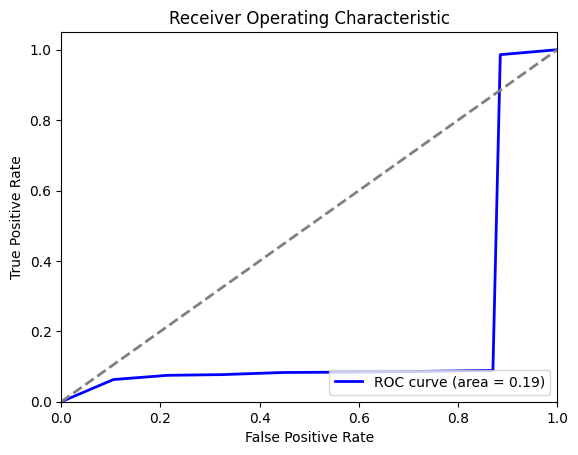

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Define the CNN model with Dropout
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Load CIFAR-10 dataset with data augmentation
def load_data(batch_size):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # Random cropping with padding
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

# Label smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, outputs, targets):
        n_classes = outputs.size(1)
        smooth_labels = torch.full(size=(targets.size(0), n_classes), fill_value=self.smoothing / (n_classes - 1)).to(outputs.device)
        smooth_labels.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)
        log_probs = torch.log_softmax(outputs, dim=1)
        return -(smooth_labels * log_probs).sum(dim=1).mean()

# Train the model
def train_model(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Track accuracy and loss
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track accuracy and loss
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Store all labels and predictions for metrics calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_loss = running_loss / len(test_loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy, np.array(all_labels), np.array(all_preds)

# Function to plot ROC curve
def plot_roc_curve(all_labels, all_preds):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Train and evaluate function
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = CNNModel().to(device)
    criterion = LabelSmoothingLoss(smoothing=0.1)  # Using Label Smoothing
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)

    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, scheduler, device)
        test_loss, test_acc, all_labels, all_preds = evaluate_model(model, test_loader, criterion, device)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        # Print confusion matrix and F1 score at the last epoch
        if epoch == num_epochs - 1:
            print("Confusion Matrix:")
            cm = confusion_matrix(all_labels, all_preds)
            print(cm)
            
            f1 = f1_score(all_labels, all_preds, average='weighted')
            print(f"F1 Score (Weighted): {f1:.4f}")

            # Plot ROC curve
            plot_roc_curve(all_labels, all_preds)

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    run_experiment(batch_size=128, learning_rate=0.1, num_epochs=10, device=device)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model
import mlflow
import mlflow.pytorch
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Vision Transformer Model
class TinyViT(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyViT, self).__init__()
        self.vit = create_model('deit_tiny_patch16_224', pretrained=True)
        self.vit.head = nn.Linear(self.vit.embed_dim, num_classes)

    def forward(self, x):
        return self.vit(x)

# Load CIFAR-10 dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / len(train_loader.dataset)
    return total_loss / len(train_loader), accuracy

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / len(test_loader.dataset)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)
    return total_loss / len(test_loader), accuracy, f1, cm

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Main function with MLflow
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 10

    train_loader, test_loader = load_data(batch_size)
    model = TinyViT(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc, f1, cm = evaluate_model(model, test_loader, criterion, device)
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        mlflow.pytorch.log_model(model, "vit_model")
        print("Model logged in MLflow.")

if __name__ == "__main__":
    main()


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10


KeyboardInterrupt: 

: 

Files already downloaded and verified
Files already downloaded and verified


2024/12/01 10:38:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Files already downloaded and verified
Files already downloaded and verified


2024/12/01 11:16:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Files already downloaded and verified
Files already downloaded and verified


2024/12/01 11:51:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Files already downloaded and verified
Files already downloaded and verified


2024/12/01 12:36:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Files already downloaded and verified
Files already downloaded and verified


2024/12/01 12:59:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Files already downloaded and verified
Files already downloaded and verified


2024/12/01 13:15:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Files already downloaded and verified
Files already downloaded and verified


2024/12/01 14:30:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import mlflow
import mlflow.pytorch

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Load CIFAR-10 dataset with data augmentation
def load_data(batch_size):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

# Label smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, outputs, targets):
        n_classes = outputs.size(1)
        smooth_labels = torch.full(size=(targets.size(0), n_classes), fill_value=self.smoothing / (n_classes - 1)).to(outputs.device)
        smooth_labels.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)
        log_probs = torch.log_softmax(outputs, dim=1)
        return -(smooth_labels * log_probs).sum(dim=1).mean()

# Train the model
def train_model(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Track accuracy and loss
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track accuracy and loss
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

# Hyperparameter tuning and MLflow integration
def hyperparameter_tuning(param_grid, num_epochs, device):
    best_acc = 0.0
    best_params = {}

    for batch_size in param_grid['batch_size']:
        for learning_rate in param_grid['learning_rate']:
            with mlflow.start_run():
                mlflow.log_param("batch_size", batch_size)
                mlflow.log_param("learning_rate", learning_rate)

                # Run the experiment
                train_loader, test_loader = load_data(batch_size)
                model = CNNModel().to(device)
                criterion = LabelSmoothingLoss(smoothing=0.1)
                optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
                scheduler = OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=num_epochs)

                for epoch in range(num_epochs):
                    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, scheduler, device)
                    test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

                    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

                    # Log metrics
                    mlflow.log_metric("Train Loss", train_loss, step=epoch)
                    mlflow.log_metric("Train Accuracy", train_acc, step=epoch)
                    mlflow.log_metric("Test Loss", test_loss, step=epoch)
                    mlflow.log_metric("Test Accuracy", test_acc, step=epoch)

                # Save the model to MLflow
                mlflow.pytorch.log_model(model, "model")

                # Track the best hyperparameters
                if test_acc > best_acc:
                    best_acc = test_acc
                    best_params = {'batch_size': batch_size, 'learning_rate': learning_rate}

    print(f"Best Accuracy: {best_acc:.2f}% with Parameters: {best_params}")
    return best_params

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define hyperparameter grid
    param_grid = {
        'batch_size': [64, 128],         # Optimal batch sizes
        'learning_rate': [0.05, 0.1],   # Learning rates tested for OneCycleLR
    }

    # Run hyperparameter tuning for 10 epochs
    best_params = hyperparameter_tuning(param_grid, num_epochs=10, device=device)

Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.9072, Train Acc: 34.91%, Test Loss: 1.6840, Test Acc: 46.41%
Epoch 2/10, Train Loss: 1.7827, Train Acc: 41.61%, Test Loss: 1.4787, Test Acc: 57.47%
Epoch 3/10, Train Loss: 1.5788, Train Acc: 52.70%, Test Loss: 1.4020, Test Acc: 62.40%
Epoch 4/10, Train Loss: 1.4947, Train Acc: 57.31%, Test Loss: 1.3810, Test Acc: 62.61%
Epoch 5/10, Train Loss: 1.4333, Train Acc: 60.41%, Test Loss: 1.2909, Test Acc: 66.97%
Epoch 6/10, Train Loss: 1.3911, Train Acc: 62.80%, Test Loss: 1.3037, Test Acc: 66.72%
Epoch 7/10, Train Loss: 1.3462, Train Acc: 64.84%, Test Loss: 1.1695, Test Acc: 73.52%
Epoch 8/10, Train Loss: 1.2939, Train Acc: 67.68%, Test Loss: 1.1452, Test Acc: 74.62%
Epoch 9/10, Train Loss: 1.2443, Train Acc: 70.11%, Test Loss: 1.1097, Test Acc: 76.19%
Epoch 10/10, Train Loss: 1.2020, Train Acc: 72.10%, Test Loss: 1.0899, Test Acc: 76.89%


2024/12/01 15:33:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.9998, Train Acc: 29.70%, Test Loss: 1.7544, Test Acc: 42.99%
Epoch 2/10, Train Loss: 1.7703, Train Acc: 42.42%, Test Loss: 1.6156, Test Acc: 48.10%
Epoch 3/10, Train Loss: 1.6307, Train Acc: 50.13%, Test Loss: 1.5036, Test Acc: 55.66%
Epoch 4/10, Train Loss: 1.5679, Train Acc: 53.82%, Test Loss: 1.5183, Test Acc: 58.43%
Epoch 5/10, Train Loss: 1.5197, Train Acc: 56.15%, Test Loss: 1.3523, Test Acc: 63.45%
Epoch 6/10, Train Loss: 1.4770, Train Acc: 58.68%, Test Loss: 1.2878, Test Acc: 67.96%
Epoch 7/10, Train Loss: 1.4262, Train Acc: 60.91%, Test Loss: 1.2589, Test Acc: 69.26%
Epoch 8/10, Train Loss: 1.3671, Train Acc: 63.96%, Test Loss: 1.1899, Test Acc: 72.50%
Epoch 9/10, Train Loss: 1.2901, Train Acc: 67.83%, Test Loss: 1.1348, Test Acc: 74.99%
Epoch 10/10, Train Loss: 1.2288, Train Acc: 71.08%, Test Loss: 1.1130, Test Acc: 76.18%


2024/12/01 15:58:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.8855, Train Acc: 35.81%, Test Loss: 1.6370, Test Acc: 49.59%
Epoch 2/10, Train Loss: 1.7807, Train Acc: 41.66%, Test Loss: 1.5599, Test Acc: 53.00%
Epoch 3/10, Train Loss: 1.6529, Train Acc: 48.69%, Test Loss: 1.4725, Test Acc: 56.44%
Epoch 4/10, Train Loss: 1.5343, Train Acc: 54.62%, Test Loss: 1.3589, Test Acc: 63.71%
Epoch 5/10, Train Loss: 1.4635, Train Acc: 58.49%, Test Loss: 1.3386, Test Acc: 64.62%
Epoch 6/10, Train Loss: 1.4130, Train Acc: 61.63%, Test Loss: 1.2395, Test Acc: 69.76%
Epoch 7/10, Train Loss: 1.3680, Train Acc: 63.87%, Test Loss: 1.2324, Test Acc: 70.92%
Epoch 8/10, Train Loss: 1.3218, Train Acc: 66.06%, Test Loss: 1.1771, Test Acc: 72.86%
Epoch 9/10, Train Loss: 1.2771, Train Acc: 68.48%, Test Loss: 1.1338, Test Acc: 75.10%
Epoch 10/10, Train Loss: 1.2449, Train Acc: 69.91%, Test Loss: 1.1194, Test Acc: 75.31%


2024/12/01 16:42:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.9025, Train Acc: 34.81%, Test Loss: 1.7642, Test Acc: 42.47%
Epoch 2/10, Train Loss: 1.8032, Train Acc: 40.31%, Test Loss: 1.5563, Test Acc: 53.12%
Epoch 3/10, Train Loss: 1.6099, Train Acc: 50.95%, Test Loss: 1.4369, Test Acc: 59.52%
Epoch 4/10, Train Loss: 1.5156, Train Acc: 55.99%, Test Loss: 1.3997, Test Acc: 60.27%
Epoch 5/10, Train Loss: 1.4540, Train Acc: 59.52%, Test Loss: 1.3459, Test Acc: 64.35%
Epoch 6/10, Train Loss: 1.4069, Train Acc: 61.96%, Test Loss: 1.2740, Test Acc: 68.03%
Epoch 7/10, Train Loss: 1.3670, Train Acc: 64.16%, Test Loss: 1.2268, Test Acc: 70.73%
Epoch 8/10, Train Loss: 1.3170, Train Acc: 66.56%, Test Loss: 1.1880, Test Acc: 72.54%
Epoch 9/10, Train Loss: 1.2704, Train Acc: 68.94%, Test Loss: 1.1216, Test Acc: 75.90%
Epoch 10/10, Train Loss: 1.2245, Train Acc: 71.20%, Test Loss: 1.1064, Test Acc: 76.24%


2024/12/01 17:12:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Accuracy: 76.89% with Parameters: {'batch_size': 64, 'learning_rate': 0.05}


Running experiment with params: {'batch_size': 32, 'learning_rate': 0.0003, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.1985, Train Acc: 57.50%, Test Loss: 0.8364, Test Acc: 70.79%, F1 Score: 0.7053
Epoch 2/10, Train Loss: 0.7925, Train Acc: 72.23%, Test Loss: 0.7138, Test Acc: 75.16%, F1 Score: 0.7522
Epoch 3/10, Train Loss: 0.6168, Train Acc: 78.61%, Test Loss: 0.6417, Test Acc: 78.15%, F1 Score: 0.7787
Epoch 4/10, Train Loss: 0.4780, Train Acc: 83.36%, Test Loss: 0.6376, Test Acc: 78.51%, F1 Score: 0.7855
Epoch 5/10, Train Loss: 0.3692, Train Acc: 87.04%, Test Loss: 0.6193, Test Acc: 80.14%, F1 Score: 0.8013
Epoch 6/10, Train Loss: 0.2889, Train Acc: 89.91%, Test Loss: 0.6379, Test Acc: 80.66%, F1 Score: 0.8067
Epoch 7/10, Train Loss: 0.2336, Train Acc: 91.89%, Test Loss: 0.6470, Test Acc: 80.85%, F1 Score: 0.8080
Epoch 8/10, Train Loss: 0.1838, Train Acc: 93.57%, Test Loss: 0.7277, Test Acc: 80.86%, F1 Scor

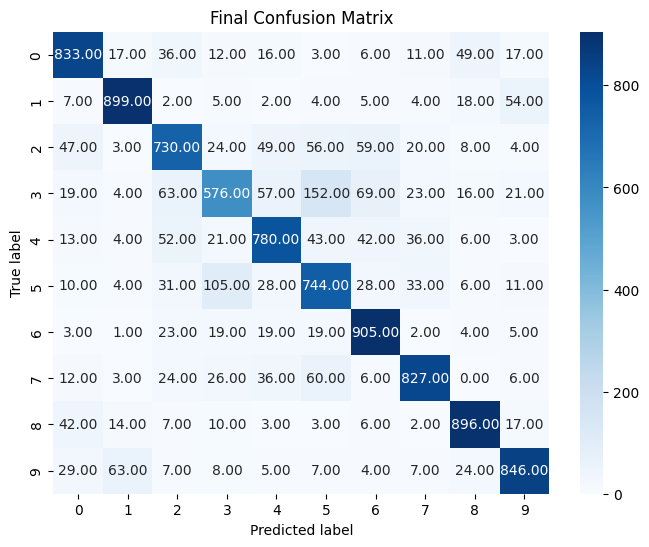

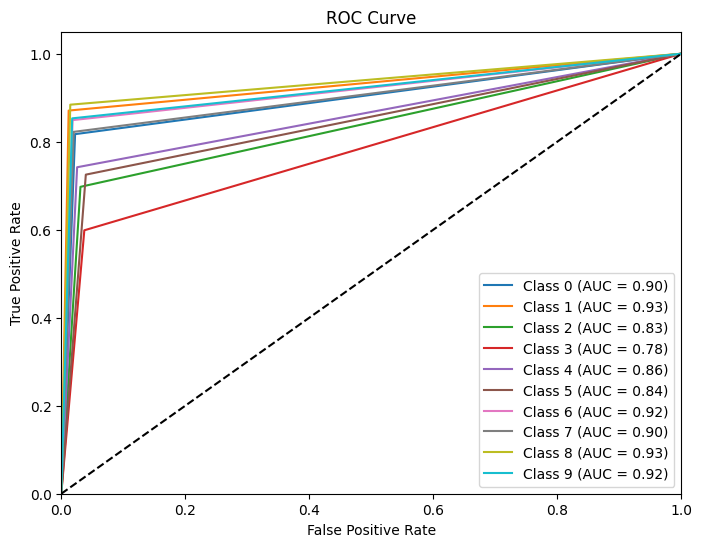

2024/12/03 21:25:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.
Running experiment with params: {'batch_size': 64, 'learning_rate': 0.0003, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 1.1783, Train Acc: 58.05%, Test Loss: 0.8619, Test Acc: 69.93%, F1 Score: 0.6936
Epoch 2/10, Train Loss: 0.7776, Train Acc: 72.79%, Test Loss: 0.6850, Test Acc: 75.90%, F1 Score: 0.7582
Epoch 3/10, Train Loss: 0.5976, Train Acc: 79.23%, Test Loss: 0.6333, Test Acc: 78.18%, F1 Score: 0.7803
Epoch 4/10, Train Loss: 0.4608, Train Acc: 83.81%, Test Loss: 0.6155, Test Acc: 78.81%, F1 Score: 0.7869
Epoch 5/10, Train Loss: 0.3390, Train Acc: 88.20%, Test Loss: 0.6392, Test Acc: 79.61%, F1 Score: 0.7950
Epoch 6/10, Train Loss: 0.2467, Train Acc: 91.39%, Test Loss: 0.6568, Test Acc: 80.20%, F1 Score: 0.8015
Epoch 7/10, Train Loss: 0.1890, Train Acc: 93.36%, Test Loss: 0.7083, Test Acc: 79.79%, F1 Score: 0.7976
Epoch 8/10, Train Loss: 0.1538, Train Acc: 94.67%, Test Loss: 0.7784, T

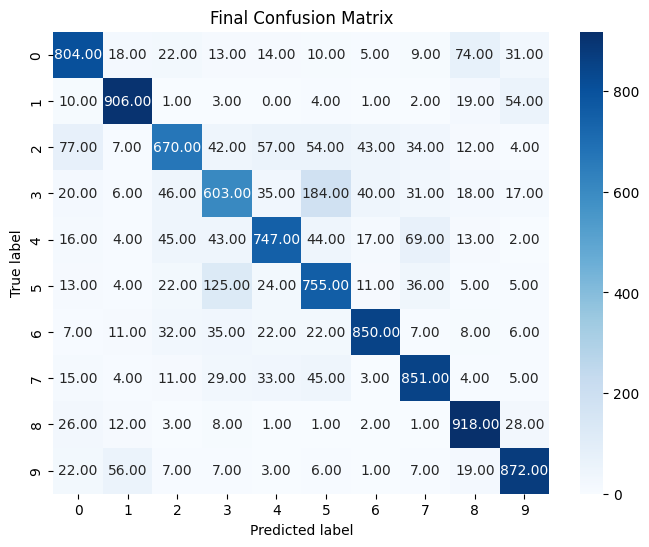

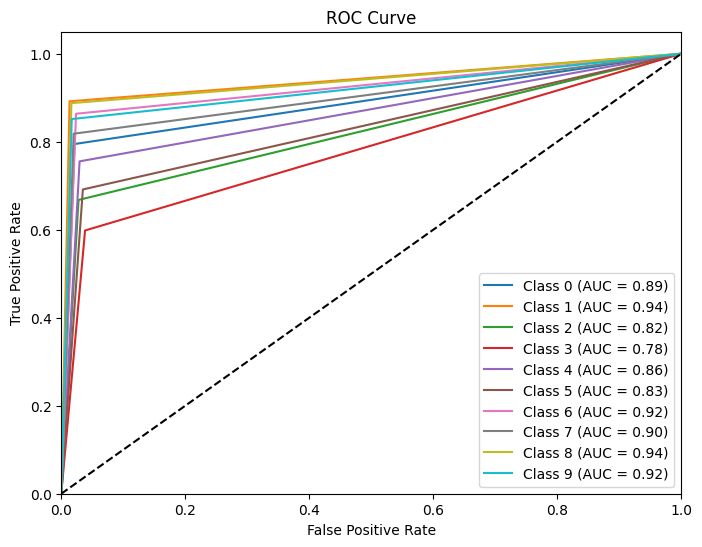

2024/12/03 22:33:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from mlflow.exceptions import MlflowException
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns  # This will work once seaborn is installed

# Define the improved CNN model with dropout, batch normalization, and additional layers
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Increase the number of filters
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Increased filters for more feature extraction
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Added an extra convolutional layer
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),  # Increased the size of the fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Load CIFAR-10 Dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
   
    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
   
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
   
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
   
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = ImprovedCNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    all_labels = []
    all_predictions = []
   
    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)
           
            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 32, "learning_rate": 0.0003, "num_epochs": 10},
        {"batch_size": 64, "learning_rate": 0.0003, "num_epochs": 10}
    ]

    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns

# Vision Transformer Model with Enhancements
class VisionTransformerEnhanced(nn.Module):
    def __init__(self, image_size=32, patch_size=4, num_classes=10, dim=512, depth=12, heads=8, mlp_dim=1024, dropout=0.2):
        super(VisionTransformerEnhanced, self).__init__()
        assert dim % heads == 0, "Embedding dimension must be divisible by the number of heads."
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = 3 * patch_size * patch_size

        # Patch embedding
        self.patch_embed = nn.Linear(self.patch_dim, dim)

        # Positional embedding with learnable embeddings
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)

        # Transformer encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout, batch_first=True), num_layers=depth
        )

        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        # Prepare patches manually (replacing einops functionality)
        patches = x.unfold(2, 4, 4).unfold(3, 4, 4)  # unfolding the image into patches
        patches = patches.contiguous().view(b, self.num_patches, -1)  # reshaping patches
        x = self.patch_embed(patches)

        # Add positional embeddings
        cls_tokens = self.cls_token.expand(b, -1, -1)  # repeat cls_token for batch size
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positional_embedding[:, : x.size(1)]
        x = self.dropout(x)

        # Pass through transformer
        x = self.transformer(x)

        # Classification token output
        cls_output = x[:, 0]
        return self.mlp_head(cls_output)

# Load CIFAR-10 Dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_vit_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = VisionTransformerEnhanced().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decrease LR every 5 epochs

    all_labels = []
    all_predictions = []
    
    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)
            
            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

            # Step the scheduler after each epoch
            scheduler.step()

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "vit_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 32, "learning_rate": 0.0005, "num_epochs": 10},
        {"batch_size": 64, "learning_rate": 0.0005, "num_epochs": 10}
    ]

    for params in hyperparams:
        print(f"Running ViT experiment with params: {params}")
        run_vit_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)


Running ViT experiment with params: {'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

Files already downloaded and verified
Files already downloaded and verified


C:\Users\tejal\AppData\Local\Temp\ipykernel_53056\2746370191.py:173: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision
c:\Deep_Learning_project\DS-677-Project\.venv\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\tejal\AppData\Local\Temp\ipykernel_53056\2746370191.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Deep_Learning_project\DS-677-Project\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/5, Train Loss: 2.4253, Train Acc: 11.40%, Test Loss: 2.2839, Test Acc: 13.60%, F1 Score: 0.0595


C:\Users\tejal\AppData\Local\Temp\ipykernel_53056\2746370191.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Deep_Learning_project\DS-677-Project\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2/5, Train Loss: 2.3198, Train Acc: 14.30%, Test Loss: 2.2718, Test Acc: 11.30%, F1 Score: 0.0350


C:\Users\tejal\AppData\Local\Temp\ipykernel_53056\2746370191.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Deep_Learning_project\DS-677-Project\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 3/5, Train Loss: 2.2909, Train Acc: 14.10%, Test Loss: 2.2359, Test Acc: 16.60%, F1 Score: 0.0749


C:\Users\tejal\AppData\Local\Temp\ipykernel_53056\2746370191.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Deep_Learning_project\DS-677-Project\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 4/5, Train Loss: 2.2170, Train Acc: 15.60%, Test Loss: 2.1876, Test Acc: 19.30%, F1 Score: 0.1018


C:\Users\tejal\AppData\Local\Temp\ipykernel_53056\2746370191.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Deep_Learning_project\DS-677-Project\.venv\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 5/5, Train Loss: 2.2219, Train Acc: 15.10%, Test Loss: 2.1665, Test Acc: 16.50%, F1 Score: 0.0726


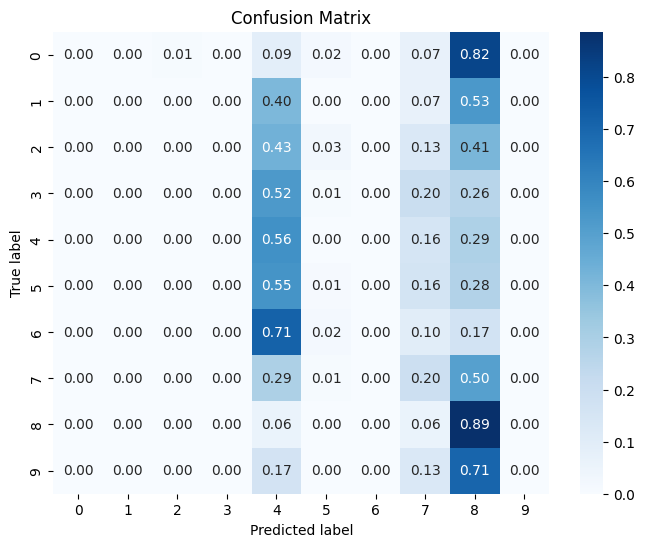

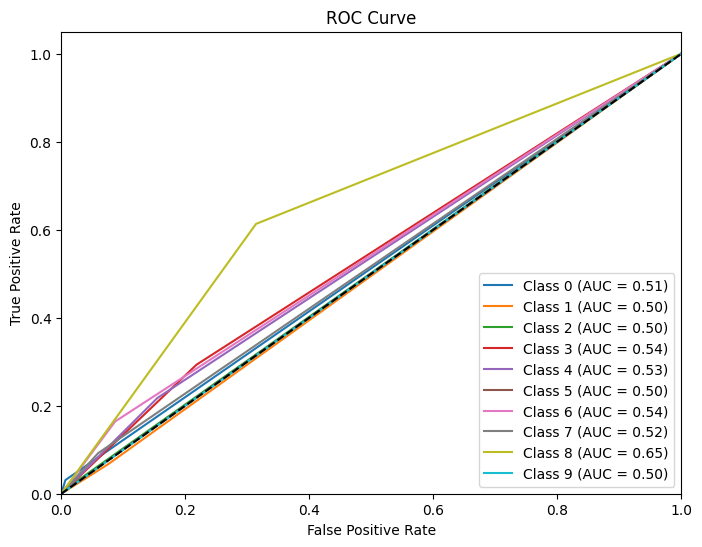

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler

# Vision Transformer Model with Optimizations
class VisionTransformerEnhanced(nn.Module):
    def __init__(self, image_size=32, patch_size=4, num_classes=10, dim=256, depth=6, heads=4, mlp_dim=1024, dropout=0.2):
        super(VisionTransformerEnhanced, self).__init__()
        assert dim % heads == 0, "Embedding dimension must be divisible by the number of heads."
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = 3 * patch_size * patch_size

        # Patch embedding
        self.patch_embed = nn.Linear(self.patch_dim, dim)

        # Positional embedding with learnable embeddings
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)

        # Transformer encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout, batch_first=True), num_layers=depth
        )

        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        # Prepare patches manually (replacing einops functionality)
        patches = x.unfold(2, 4, 4).unfold(3, 4, 4)  # unfolding the image into patches
        patches = patches.contiguous().view(b, self.num_patches, -1)  # reshaping patches
        x = self.patch_embed(patches)

        # Add positional embeddings
        cls_tokens = self.cls_token.expand(b, -1, -1)  # repeat cls_token for batch size
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positional_embedding[:, : x.size(1)]
        x = self.dropout(x)

        # Pass through transformer
        x = self.transformer(x)

        # Classification token output
        cls_output = x[:, 0]
        return self.mlp_head(cls_output)

# Load CIFAR-10 Dataset with a Subset for Faster Testing
def load_data(batch_size, subset_size=1000):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    
    # Use only a subset of the data for faster testing
    train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
    test_dataset = torch.utils.data.Subset(test_dataset, range(subset_size))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, test_loader

# Train the model with Mixed Precision
def train_model(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Mixed precision
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_vit_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = VisionTransformerEnhanced(dim=256, depth=6, heads=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decrease LR every 5 epochs
    scaler = GradScaler()  # For mixed precision

    all_labels = []
    all_predictions = []
    
    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device, scaler)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)
            
            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_accuracy", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

            # Learning rate scheduler step
            scheduler.step()

        # Plot confusion matrix
        plot_confusion_matrix(cm, classes=[str(i) for i in range(10)], normalize=True)
        
        # Plot ROC Curve
        plot_roc_curve(all_labels, all_predictions)

# Set device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run the experiment with the specified parameters
run_vit_experiment(batch_size=32, learning_rate=0.0005, num_epochs=5, device=device)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from mlflow.exceptions import MlflowException
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns

# Vision Transformer Model Definition
class VisionTransformer(nn.Module):
    def __init__(self, image_size=32, patch_size=4, num_classes=10, dim=256, depth=6, heads=4, mlp_dim=1024, dropout=0.2):
        super(VisionTransformer, self).__init__()
        assert dim % heads == 0, "Embedding dimension must be divisible by the number of heads."
        
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = 3 * patch_size * patch_size
        
        # Patch embedding
        self.patch_embed = nn.Linear(self.patch_dim, dim)
        
        # Positional embedding with learnable embeddings
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout, batch_first=True), num_layers=depth
        )
        
        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        # Prepare patches manually (replacing einops functionality)
        patches = x.unfold(2, 4, 4).unfold(3, 4, 4)  # unfolding the image into patches
        patches = patches.contiguous().view(b, self.num_patches, -1)  # reshaping patches
        x = self.patch_embed(patches)

        # Add positional embeddings
        cls_tokens = self.cls_token.expand(b, -1, -1)  # repeat cls_token for batch size
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positional_embedding[:, : x.size(1)]
        x = self.dropout(x)

        # Pass through transformer
        x = self.transformer(x)

        # Classification token output
        cls_output = x[:, 0]
        return self.mlp_head(cls_output)

# Load CIFAR-10 Dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = VisionTransformer(dim=256, depth=6, heads=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decrease LR every 5 epochs

    all_labels = []
    all_predictions = []

    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)

            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

            # Step the scheduler after each epoch
            scheduler.step()

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "vit_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 32, "learning_rate": 0.0005, "num_epochs": 10},
        {"batch_size": 64, "learning_rate": 0.0005, "num_epochs": 10}
    ]

    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)


Running experiment with params: {'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Train Loss: 2.2940, Train Acc: 12.20%, Test Loss: 2.3046, Test Acc: 10.34%, F1 Score: 0.0269
Epoch 2/10, Train Loss: 2.3088, Train Acc: 10.13%, Test Loss: 2.3053, Test Acc: 10.00%, F1 Score: 0.0182


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns

# Vision Transformer Model Definition
class VisionTransformer(nn.Module):
    def __init__(self, image_size=32, patch_size=4, num_classes=10, dim=512, depth=8, heads=8, mlp_dim=1024, dropout=0.2):
        super(VisionTransformer, self).__init__()
        assert dim % heads == 0, "Embedding dimension must be divisible by the number of heads."
        
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = 3 * patch_size * patch_size
        
        # Patch embedding
        self.patch_embed = nn.Linear(self.patch_dim, dim)
        
        # Positional embedding with learnable embeddings
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout, batch_first=True), num_layers=depth
        )
        
        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        # Prepare patches manually (replacing einops functionality)
        patches = x.unfold(2, 4, 4).unfold(3, 4, 4)  # unfolding the image into patches
        patches = patches.contiguous().view(b, self.num_patches, -1)  # reshaping patches
        x = self.patch_embed(patches)

        # Add positional embeddings
        cls_tokens = self.cls_token.expand(b, -1, -1)  # repeat cls_token for batch size
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positional_embedding[:, : x.size(1)]
        x = self.dropout(x)

        # Pass through transformer
        x = self.transformer(x)

        # Classification token output
        cls_output = x[:, 0]
        return self.mlp_head(cls_output)

# Load CIFAR-10 Dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = VisionTransformer(dim=512, depth=8, heads=8).to(device)  # Increased model size
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # AdamW optimizer
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)  # Cosine annealing scheduler

    all_labels = []
    all_predictions = []

    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)

            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

            # Step the scheduler after each epoch
            scheduler.step()

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "vit_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    learning_rate = 1e-3
    num_epochs = 20
    run_experiment(batch_size, learning_rate, num_epochs, device)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision.models import vit_b_16  # Using PyTorch's built-in ViT model

# Define Vision Transformer model using PyTorch's built-in model
class VisionTransformerModel(nn.Module):
    def __init__(self, pretrained=True):
        super(VisionTransformerModel, self).__init__()
        # Load pre-trained Vision Transformer (ViT) model from PyTorch
        self.model = vit_b_16(pretrained=pretrained)
        # The final layer is a Sequential module, get its last linear layer to determine the input size
        final_layer = self.model.heads[0]  # Get the final linear layer
        in_features = final_layer.in_features  # Get the number of input features
        # Replace the classifier layer with a new Linear layer for CIFAR-10 (10 classes)
        self.model.heads = nn.Linear(in_features, 10)

    def forward(self, x):
        return self.model(x)

# Load CIFAR-10 Dataset with resize transform
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.Resize(224),  # Resize images to 224x224
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
   
    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')
   
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
   
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
   
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = VisionTransformerModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decrease LR every 5 epochs

    all_labels = []
    all_predictions = []
   
    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)
           
            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

            # Step the scheduler after each epoch
            scheduler.step()

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "vit_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 32, "learning_rate": 0.0005, "num_epochs": 10},
        {"batch_size": 64, "learning_rate": 0.0005, "num_epochs": 10}
    ]

    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)


Running experiment with params: {'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

In [13]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision.models import vit_b_16  # Using PyTorch's built-in ViT model

# Define Vision Transformer model using PyTorch's built-in model
class VisionTransformerModel(nn.Module):
    def __init__(self, pretrained=True):
        super(VisionTransformerModel, self).__init__()
        # Load pre-trained Vision Transformer (ViT) model from PyTorch
        self.model = vit_b_16(pretrained=pretrained)

        # Inspect the model structure and print it
        print(self.model)

        # Replace the classifier head with a new Linear layer for CIFAR-10 (10 classes)
        # The classification head is within 'self.model.heads', which is a Sequential container
        # We need to replace the last layer of the 'heads' sequential block
        num_features = self.model.heads[0].in_features  # Get the 'in_features' of the last layer
        self.model.heads = nn.Linear(num_features, 10)  # Replace with CIFAR-10 output (10 classes)

    def forward(self, x):
        return self.model(x)

# Load CIFAR-10 Dataset with resize transform
def load_data(batch_size, num_workers=4):
    transform = transforms.Compose([
        transforms.Resize(224),  # Resize images to 224x224
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = VisionTransformerModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decrease LR every 5 epochs

    all_labels = []
    all_predictions = []

    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)

            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

            # Step the scheduler after each epoch
            scheduler.step()

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "vit_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
       
        {"batch_size": 64, "learning_rate": 0.0005, "num_epochs": 10}
    ]

    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)


Running experiment with params: {'batch_size': 64, 'learning_rate': 0.0005, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dr

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision.models import vit_b_16  # Using PyTorch's built-in ViT model
import time

# Define Vision Transformer model using PyTorch's built-in model
class VisionTransformerModel(nn.Module):
    def __init__(self, pretrained=True):
        super(VisionTransformerModel, self).__init__()
        # Load pre-trained Vision Transformer (ViT) model from PyTorch
        self.model = vit_b_16(pretrained=pretrained)
        # Access the classifier head and replace it with a new Linear layer for CIFAR-10 (10 classes)
        in_features = self.model.heads.head.in_features
        self.model.heads = nn.Linear(in_features, 10)

    def forward(self, x):
        return self.model(x)

# Load CIFAR-10 Dataset with resize transform
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.Resize(224),  # Resize images to 224x224 for ViT
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute F1 Score
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(all_labels, all_predictions, num_classes=10):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning and MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = VisionTransformerModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decrease LR every 5 epochs

    all_labels = []
    all_predictions = []

    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            start_time = time.time()  # Track time for the epoch

            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            # Testing phase
            test_loss, test_acc, f1, cm, epoch_labels, epoch_predictions = evaluate_model(model, test_loader, criterion, device)

            # Append all labels and predictions for later use
            all_labels.extend(epoch_labels)
            all_predictions.extend(epoch_predictions)

            # Log metrics to MLflow
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

            # Step the scheduler after each epoch
            scheduler.step()

            # Print epoch duration
            epoch_duration = time.time() - start_time
            print(f"Epoch {epoch + 1} completed in {epoch_duration:.2f} seconds")

        # Plot confusion matrix and ROC curve after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        plot_roc_curve(all_labels, all_predictions)

        # Log the final model
        mlflow.pytorch.log_model(model, "vit_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 32, "learning_rate": 0.0005, "num_epochs": 10},
        {"batch_size": 64, "learning_rate": 0.0005, "num_epochs": 10}
    ]

    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)


Running experiment with params: {'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from sklearn.metrics import confusion_matrix, f1_score
from timm.models.vision_transformer import vit_base_patch16_224
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

# Improved Vision Transformer Model
class ImprovedViT(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedViT, self).__init__()
        self.vit = vit_base_patch16_224(pretrained=True)
        self.vit.head = nn.Linear(self.vit.embed_dim, num_classes)

    def forward(self, x):
        return self.vit(x)

# Load CIFAR-10 Dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.Resize(224),  # Resize for pre-trained ViT
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model with debug logging
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        start_time = time.time()  # Start timer
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        end_time = time.time()  # End timer
        print(f"Batch {batch_idx + 1}/{len(train_loader)}, Time: {end_time - start_time:.2f}s")
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Run experiment with MLflow logging and debug prints
def run_experiment(batch_size, learning_rate, num_epochs, device):
    train_loader, test_loader = load_data(batch_size)
    model = ImprovedViT().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

            # Testing phase
            test_loss, test_acc, f1, cm, _, _ = evaluate_model(model, test_loader, criterion, device)
            print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

        # Plot confusion matrix after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        mlflow.pytorch.log_model(model, "vit_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = [
        {"batch_size": 32, "learning_rate": 0.0005, "num_epochs": 10},
        {"batch_size": 64, "learning_rate": 0.0005, "num_epochs": 10}
    ]
    for params in hyperparams:
        print(f"Running experiment with params: {params}")
        run_experiment(params["batch_size"], params["learning_rate"], params["num_epochs"], device)

c:\Deep_Learning_project\DS-677-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running experiment with params: {'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 10}
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/10
Batch 1/1563, Time: 73.27s
Batch 2/1563, Time: 88.77s
Batch 3/1563, Time: 87.76s
Batch 4/1563, Time: 53.99s
Batch 5/1563, Time: 45.09s
Batch 6/1563, Time: 46.72s
Batch 7/1563, Time: 50.41s
Batch 8/1563, Time: 55.43s
Batch 9/1563, Time: 30.14s
Batch 10/1563, Time: 32.22s
Batch 11/1563, Time: 33.14s
Batch 12/1563, Time: 33.74s
Batch 13/1563, Time: 33.83s
Batch 14/1563, Time: 26.27s
Batch 15/1563, Time: 35.33s
Batch 16/1563, Time: 98.77s
Batch 17/1563, Time: 93.54s
Batch 18/1563, Time: 80.99s
Batch 19/1563, Time: 47.11s
Batch 20/1563, Time: 37.58s
Batch 21/1563, Time: 16.97s
Batch 22/1563, Time: 17.35s
Batch 23/1563, Time: 17.32s
Batch 24/1563, Time: 17.94s
Batch 25/1563, Time: 19.34s
Batch 26/1563, Time: 18.99s
Batch 27/1563, Time: 19.99s
Batch 28/1563, Time: 21.02s
Batch 29/1563, Time: 21.64s
Batch 30/1563, 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
from sklearn.metrics import confusion_matrix, f1_score
from timm.models.vision_transformer import vit_base_patch16_224
from timm.data.mixup import Mixup
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

# Improved Vision Transformer Model
class ImprovedViT(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedViT, self).__init__()
        self.vit = vit_base_patch16_224(pretrained=True)
        self.vit.head = nn.Sequential(
            nn.Dropout(0.3),  # Dropout to improve generalization
            nn.Linear(self.vit.embed_dim, num_classes)
        )

    def forward(self, x):
        return self.vit(x)

# Load CIFAR-10 Dataset with MixUp
def load_data(batch_size, mixup_alpha=0.2):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.Resize(224),  # Resize for pre-trained ViT
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    mixup_fn = Mixup(mixup_alpha=mixup_alpha, num_classes=10) if mixup_alpha > 0 else None
    return train_loader, test_loader, mixup_fn

# Train the model with MixUp
def train_model(model, train_loader, criterion, optimizer, device, mixup_fn=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        if mixup_fn:
            images, labels = mixup_fn(images, labels)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item() if mixup_fn else (predicted == labels).sum().item()
    return total_loss / len(train_loader), 100 * correct / total

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    cm = confusion_matrix(all_labels, all_predictions)
    return total_loss / len(test_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Run experiment with MLflow logging
def run_experiment(batch_size, learning_rate, num_epochs, device, mixup_alpha=0.2):
    train_loader, test_loader, mixup_fn = load_data(batch_size, mixup_alpha)
    model = ImprovedViT().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    with mlflow.start_run():
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("mixup_alpha", mixup_alpha)

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            # Training phase
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device, mixup_fn)
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

            # Testing phase
            test_loss, test_acc, f1, cm, _, _ = evaluate_model(model, test_loader, criterion, device)
            print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1 Score: {f1:.4f}")

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_acc", test_acc, step=epoch)
            mlflow.log_metric("f1_score", f1, step=epoch)

            scheduler.step()

        # Plot confusion matrix after all epochs
        plot_confusion_matrix(cm, classes=list(range(10)), title="Final Confusion Matrix")
        mlflow.pytorch.log_model(model, "vit_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparams = {
        "batch_size": 128,  # Larger batch size
        "learning_rate": 0.001,  # Adjusted learning rate for larger batch size
        "num_epochs": 10,  # Fixed to 10 epochs
        "mixup_alpha": 0.2  # MixUp for data augmentation
    }
    print(f"Running experiment with params: {hyperparams}")
    run_experiment(hyperparams["batch_size"], hyperparams["learning_rate"], hyperparams["num_epochs"], device, hyperparams["mixup_alpha"])


c:\Deep_Learning_project\DS-677-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running experiment with params: {'batch_size': 128, 'learning_rate': 0.001, 'num_epochs': 10, 'mixup_alpha': 0.2}
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/10


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.models.vision_transformer import vit_base_patch16_224
import matplotlib.pyplot as plt

# Simplified Vision Transformer Model
class SimpleViT(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleViT, self).__init__()
        self.vit = vit_base_patch16_224(pretrained=True)
        self.vit.head = nn.Linear(self.vit.embed_dim, num_classes)

    def forward(self, x):
        return self.vit(x)

# Load CIFAR-10 dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.Resize(224),  # Resize for ViT
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluate function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    return total_loss / len(test_loader), accuracy

# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 5

    train_loader, test_loader = load_data(batch_size)
    model = SimpleViT().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

if __name__ == "__main__":
    main()


c:\Deep_Learning_project\DS-677-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model
from timm.models.vision_transformer import deit_tiny_patch16_224

# Vision Transformer Model
class TinyViT(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyViT, self).__init__()
        self.vit = deit_tiny_patch16_224(pretrained=True)
        self.vit.head = nn.Linear(self.vit.embed_dim, num_classes)

    def forward(self, x):
        return self.vit(x)

# Load CIFAR-10 dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize for ViT
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / len(train_loader.dataset)
    return total_loss / len(train_loader), accuracy

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / len(test_loader.dataset)
    return total_loss / len(test_loader), accuracy

# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 5

    train_loader, test_loader = load_data(batch_size)
    model = TinyViT(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

if __name__ == "__main__":
    main()


ImportError: cannot import name 'deit_tiny_patch16_224' from 'timm.models.vision_transformer' (c:\Deep_Learning_project\DS-677-Project\.venv\Lib\site-packages\timm\models\vision_transformer.py)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model  # Correct import for creating models

# Vision Transformer Model
class TinyViT(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyViT, self).__init__()
        self.vit = create_model('deit_tiny_patch16_224', pretrained=True)  # Use create_model for the model
        self.vit.head = nn.Linear(self.vit.embed_dim, num_classes)  # Modify output layer for CIFAR-10

    def forward(self, x):
        return self.vit(x)

# Load CIFAR-10 dataset
def load_data(batch_size):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images for ViT
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / len(train_loader.dataset)
    return total_loss / len(train_loader), accuracy

# Evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / len(test_loader.dataset)
    return total_loss / len(test_loader), accuracy

# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 5

    train_loader, test_loader = load_data(batch_size)
    model = TinyViT(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

if __name__ == "__main__":
    main()


Files already downloaded and verified
Files already downloaded and verified


c:\Deep_Learning_project\DS-677-Project\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tejal\.cache\huggingface\hub\models--timm--deit_tiny_patch16_224.fb_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Epoch 1/5


KeyboardInterrupt: 